# Read EEG mat and stim data, write FIFs (MNE-Python) and numpy arrays

## Environment setup

In [28]:
from scipy.io import loadmat
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

## Paths to musicImagery EEG/stim data
Paths to read in data from:

In [29]:
STIM_MAT_PATH = os.path.join('..', '1-source-data', 'datasetCND_musicImagery', 'dataCND', 'dataStim.mat')
STIM_NPY_PATH = os.path.join('npy', 'stim')

EEG_MAT_PATH = os.path.join('..', '1-source-data', 'datasetCND_musicImagery', 'dataCND') # append .mat paths for each subject below

Paths to export eeg+stim data to:

In [31]:
DATA_NPY_PATH = os.path.join('npy', 'data')
DATA_FIF_PATH = os.path.join('fif')

# Load stimuli
Note: ```stimIndxs``` range from 1 to 4 and ```condIdxs``` range from 1-2.
These are _not_ 0-indexed.

In [32]:
stim_mat = loadmat(STIM_MAT_PATH, simplify_cells = True) 
stim = stim_mat['stim']
# print(stim)

stimIdxs = stim['stimIdxs']
print(f'stimIdxs shape (N trials): {stimIdxs.shape}')

condIdxs = stim['condIdxs']
print(f'condIdxs shape (N trials): {condIdxs.shape}')

condNames = stim['condNames']
print(f'condNames shape (P conditions): {condNames.shape}')

stim_events = stim['data']
print(f'events shape (M features, N trials): {stim_events.shape}')

stim_event_labels = stim['names']
print(f'event names shape (M features): {stim_event_labels.shape}')

fs_stim = stim['fs'] # ignore, use fs from data struct (64 Hz)
print(f'fs: {fs_stim} Hz')

stimIdxs shape (N trials): (88,)
condIdxs shape (N trials): (88,)
condNames shape (P conditions): (2,)
events shape (M features, N trials): (2, 88)
event names shape (M features): (2,)
fs: 64 Hz


Mapping between stim indices and names (labels)

In [33]:
# Handy mapping of indices to labels
stimId_to_Song_map = {
    2: 'chor-038', 
    1: 'chor-096', 
    3: 'chor-101',
    4: 'chor-019', 
} # from read_stim_midi.ipynb

stimLabel_to_id_map = {
    'chor-038': 2, 
    'chor-096': 1, 
    'chor-101': 3,
    'chor-019': 4, 
} # reverse mapping

stimLabel_to_sheet_order_map = {
    'chor-038': 1, 
    'chor-096': 2, 
    'chor-101': 3,
    'chor-019': 4, 
} # order of songs on sheet music

condId_to_State_map = {
    1: 'Listening', 
    2: 'Imagery'
} # from condNames

## Read prep'd stim numpy arrays
Load npy arrays for stim as saved in [2.1-stim-mat-wav-midi-to-npy.ipynb](./2.1-stim-mat-wav-midi-to-npy.ipynb)

In [34]:
stims = {}
for stimLabel in stimLabel_to_sheet_order_map.keys():
    filename = f'{stimLabel}_fs-64Hz_midi_exp_cue_env.npy'
    stims[stimLabel] = np.load(os.path.join(STIM_NPY_PATH, filename))
stims

{'chor-038': array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.05407348, 0.05469121, 0.05531164, ..., 0.25622297, 0.26207164,
         0.26869736]], shape=(4, 1803)),
 'chor-096': array([[65.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.28676142,  0.27906154,  0.26226445, ...,  0.12532383,
          0.12300036,  0.12128167]], shape=(4, 1803)),
 'chor-101': array([[77.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.       

In [35]:
stim_channel_names = ['midi', 'expectation', 'tactile_cue', 'envelope']

# Load EEG data for a subject

Make a list of raws for each subject, in original trial order

Steps needed:
- Make an MNE info object
    - Add trial condition and song name to raw's description
- Correct channel names for applying biosemi64 montage
- Add a stim channel with note and beat onsets 
    - Note, there are no overlapping events as any notes overlapped with beat onsets are removed from the stim mat files (these can still be recovered from the MIDI if needed)

In [36]:
import librosa

def annotate_notes(raw, stim_channel = 'midi'):
    events = mne.find_events(
        raw, 
        stim_channel = stim_channel,
        consecutive = True, # get up and down changes in MIDI
        initial_event = True, # for MIDI notes on first beat
        shortest_event=1, # only MIDI onsets are marked
    )

    unique_notes = np.unique(events[:, 2])
    event_id = {}
    for note in unique_notes:
        if note > 1: # ignores NaN
            event_id[note] = librosa.midi_to_note(note).replace('♯', '#')
        elif note == 1: # rest gets event ID 1, manually forced
            event_id[note] = 'rest'

    # Can't use annotations_from_events, as it doesn't get note duration
    '''
    note_annots = mne.annotations_from_events(
        events = events,
        sfreq = raw.info['sfreq'],
        event_desc = event_id,
    )
    '''

    onset = events[:, 0]/raw.info['sfreq']
    duration = np.diff(onset)
    duration = np.append(duration, [1803/raw.info['sfreq'] - onset[-1]])
    description = [event_id[n] for n in events[:, 2]]
    
    dur_in_beats = np.round(duration * 100/60, 1)/4

    events_notes_beats = []
    for i in range(len(description)):
        ev = f'{description[i]}_{dur_in_beats[i]}'
        events_notes_beats.append(ev)

    note_annots = mne.Annotations(
        onset=onset,
        duration=duration,
        description=events_notes_beats,
    )
    
    raw.set_annotations(note_annots)
    return raw

def all_raws_for_subject(
        stims, 
        stim_channel_names, 
        subjectID = 1,
    ):
    
    # Path to data for selected subject
    sub_mat = loadmat(os.path.join(EEG_MAT_PATH, f"dataSub{subjectID}.mat"), simplify_cells = True) 

    # This should be the same as fs_stim above
    fs = sub_mat['eeg']['fs']

    # EEG dataset for selected subject
    data = sub_mat['eeg']['data']

    # Randomized trial order for current subject
    orig_trial_pos = sub_mat['eeg']['origTrialPosition']
    #print(f'orig_trial_pos: {orig_trial_pos}')

    # Get current subject's song and condition ordering (since its randomized)
    thisSubStimOrder = stimIdxs[(orig_trial_pos-1)] # convert to being zero indexed
    thisSubCondOrder = condIdxs[(orig_trial_pos-1)]
    dataTrialOrder = data[(orig_trial_pos-1)]

    # EEG channel map
    chanLocs = sub_mat['eeg']['chanlocs']
    montage_chs = [] # get channel names and order from chanLocs
    for k in chanLocs:
        ch_n = k['labels'].split(' (')[0] # remove paranthesis from name
        montage_chs.append(ch_n)

    # Make an info object
    info = mne.create_info(
            ch_names=montage_chs + stim_channel_names, 
            sfreq=fs, 
            ch_types=['eeg']*len(chanLocs) + ['stim']*len(stim_channel_names)
        )
    info.set_montage('biosemi64', match_case=False) # resolves Afz case trouble

    raw_trials = []
    for trialIdx in range(88): #orig_trial_pos-1: # go back to original trial order

        # What stim and condition (state) is this trial?
        stimIdx = thisSubStimOrder[trialIdx]
        condIdx = thisSubCondOrder[trialIdx]
        condLabel = condId_to_State_map[condIdx]

        info['description'] = str(trialIdx) #f'{condId_to_State_map[condIdx]}/{stimId_to_Song_map[stimIdx]}'
        
        stimLabel = stimId_to_Song_map[stimIdx]
        #print(stim_data.shape)
        #print(data[trialIdx].shape)

        # Rescale data to Volts, Add the stim channel
        stim_data = stims[stimLabel]
        eeg_and_stim_data = np.vstack((dataTrialOrder[trialIdx].T / 1e6, stim_data))
        
        raw = mne.io.RawArray(
            data = eeg_and_stim_data, # transpose for importing to MNE
            info = info,
            verbose = 'ERROR',
        )

        # Add annotations for MIDI notes:
        raw = annotate_notes(raw, stim_channel = 'midi')

        raw.info.description = f'subject-{subjectID}_trial-'
        raw.info.description += '{:02d}'.format(trialIdx)
        raw.info.description += f'_{stimLabel}_condition-{condLabel}'
        print(raw.info.description)
        raw_trials.append(raw)

    return raw_trials

def merged_raws_for_subject(subjectID):
    
    # Collect a list of raws per subject
    raw_trials = all_raws_for_subject(subjectID = subjectID)
    #print(len(raw_trials))

    # Now concatenate these raws
    for raw in raw_trials:
        trialIdx = int(raw.info['description'])
        stimLabel = stimId_to_Song_map[stimIdxs[trialIdx]]
        condLabel = condId_to_State_map[condIdxs[trialIdx]]
        #print(f"sub{subjectID}\ttrial #{raw.info['description']}\t{condLabel}\t{stimLabel}")

        # https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html
        trial_annot = mne.Annotations(
            onset = [0],
            duration = raw[0][-1][-1], # entire duration of the trial
            description = f'{condLabel}/{stimLabel}'
        )

        raw.set_annotations(trial_annot)

    return mne.concatenate_raws(raw_trials)

# List of raws, in original trial order, by subject

Only run this cell once after the cell above?

In [37]:
ALL_RAWS = []
for subjectID in range(1, 21+1): #range(6, 21+1): #, 3, 7, 11]:
    ALL_RAWS.extend(
        all_raws_for_subject(
            stims, 
            stim_channel_names, 
            subjectID,
        )
    )
    #merged_raw_trials[subjectID] = merged_raws_for_subject(subjectID)

Finding events on: midi
33 events found on stim channel midi
Event IDs: [65 67 69 70 71 72 74]
subject-1_trial-00_chor-096_condition-Listening
Finding events on: midi
33 events found on stim channel midi
Event IDs: [65 67 69 70 71 72 74]
subject-1_trial-01_chor-096_condition-Listening
Finding events on: midi
42 events found on stim channel midi
Event IDs: [ 1 60 61 62 64 65 67 69 70 72]
subject-1_trial-02_chor-038_condition-Listening
Finding events on: midi
42 events found on stim channel midi
Event IDs: [ 1 60 61 62 64 65 67 69 70 72]
subject-1_trial-03_chor-038_condition-Listening
Finding events on: midi
50 events found on stim channel midi
Event IDs: [68 69 70 72 73 75 77 78]
subject-1_trial-04_chor-101_condition-Listening
Finding events on: midi
50 events found on stim channel midi
Event IDs: [68 69 70 72 73 75 77 78]
subject-1_trial-05_chor-101_condition-Listening
Finding events on: midi
50 events found on stim channel midi
Event IDs: [68 69 70 72 73 75 77 78]
subject-1_trial-06_c

In [38]:
ALL_RAWS

[<RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s), ~1.0 MiB, data loaded>,
 <RawArray | 68 x 1803 (28.2 s)

Using matplotlib as 2D backend.


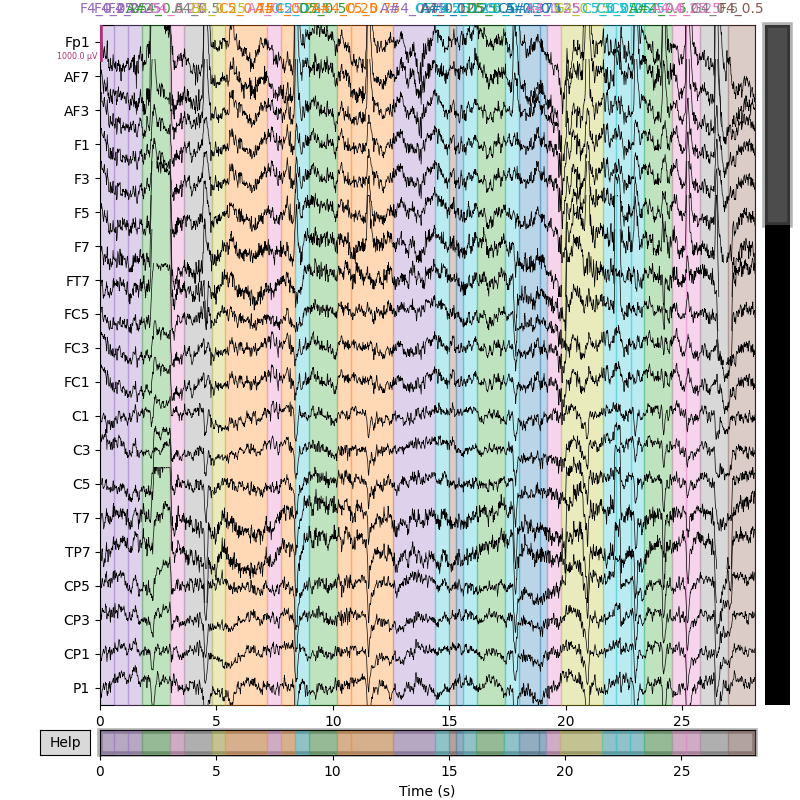

In [39]:
raw = ALL_RAWS[0]
scalings = {'eeg': 500e-6, 'stim': 200}

%matplotlib widget

fig = raw.plot(
    duration = 2.4*12,
    start = 0,
    scalings = scalings,
)

ax = fig.get_axes()[0]
ax.set_title(raw.info.description + '\n')
plt.tight_layout()

# Export Data to Numpy Arrays

In [42]:
for raw in ALL_RAWS:
    data = raw.get_data()

    filename = f'{raw.info.description}.npy'
    
    np.save(
        file=os.path.join(DATA_NPY_PATH, filename),
        arr=data
    )

# Also export FIF files

In [44]:
overwrite = not True

for raw in ALL_RAWS:
    raw.save(
        fname = os.path.join(DATA_FIF_PATH, f'{raw.info.description}_raw.fif'),
        overwrite = overwrite
    )

Writing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-00_chor-096_condition-Listening_raw.fif
Closing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-00_chor-096_condition-Listening_raw.fif
[done]
Writing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-01_chor-096_condition-Listening_raw.fif
Closing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-01_chor-096_condition-Listening_raw.fif
[done]
Writing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-02_chor-038_condition-Listening_raw.fif
Closing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-02_chor-038_condition-Listening_raw.fif
[done]
Writing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-03_chor-038_condition-Listening_raw.fif
Closing /local_disk/abhinav/eeg-blinks-music/2-mat-to-npy-fif/fif/subject-1_trial-03_chor-038_condition-Listening_raw.fif
[do

# Examine / Debug Events If Needed

Finding events on: midi
33 events found on stim channel midi
Event IDs: [65 67 69 70 71 72 74]
[[   0    0   65]
 [  38    0   65]
 [  76    0   65]
 [ 115    0   70]
 [ 192    0   67]
 [ 230    0   69]
 [ 307    0   71]
 [ 345    0   72]
 [ 460    0   69]
 [ 499    0   70]
 [ 537    0   72]
 [ 576    0   74]
 [ 652    0   70]
 [ 691    0   72]
 [ 806    0   70]
 [ 921    0   72]
 [ 960    0   69]
 [ 979    0   70]
 [ 998    0   72]
 [1036    0   74]
 [1113    0   72]
 [1152    0   72]
 [1209    0   70]
 [1228    0   69]
 [1267    0   67]
 [1382    0   72]
 [1420    0   72]
 [1459    0   72]
 [1497    0   70]
 [1574    0   69]
 [1612    0   69]
 [1651    0   67]
 [1728    0   65]]
33


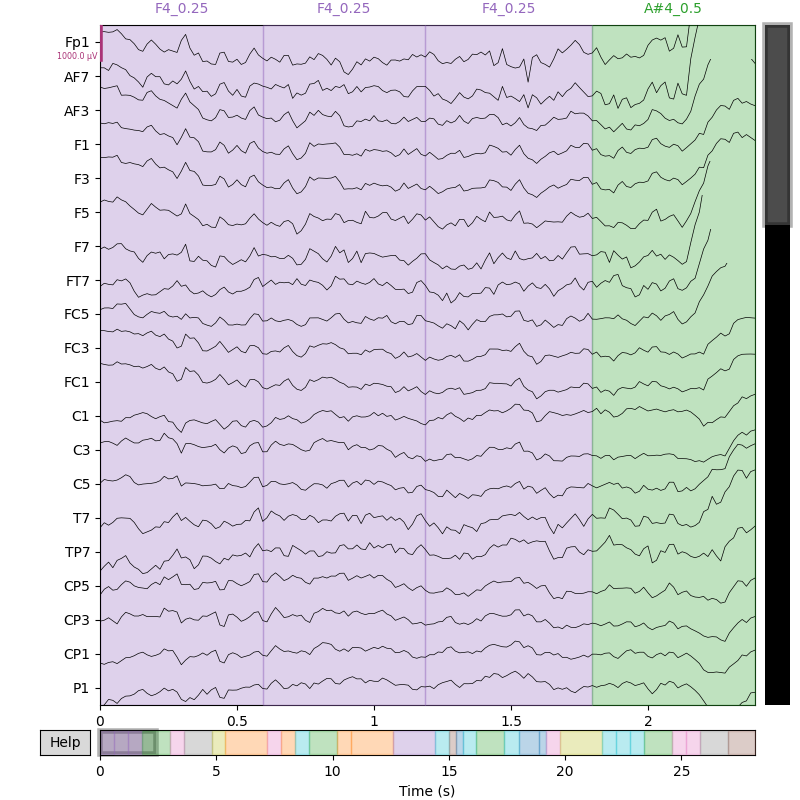

In [45]:
raw = ALL_RAWS[0]
stim_channel = 'midi'

events = mne.find_events(
    raw, 
    stim_channel = stim_channel,
    consecutive = True, # get up and down changes in MIDI
    initial_event = True, # for MIDI notes on first beat
    shortest_event=1, # only MIDI onsets are marked
)
print(events)
print(len(events))

unique_notes = np.unique(events[:, 2])
event_id = {}
for note in unique_notes:
    if note > 1: # ignores NaN
        event_id[note] = librosa.midi_to_note(note).replace('♯', '#')
    elif note == 1: # rest gets event ID 1, manually forced
        event_id[note] = 'rest'

# Can't use annotations_from_events, as it doesn't get note duration
'''
note_annots = mne.annotations_from_events(
    events = events,
    sfreq = raw.info['sfreq'],
    event_desc = event_id,
)
'''

onset = events[:, 0]/raw.info['sfreq']
duration = np.diff(onset)
duration = np.append(duration, [1803/raw.info['sfreq'] - onset[-1]])
description = [event_id[n] for n in events[:, 2]]

dur_in_beats = np.round(duration * 100/60, 1)/4

events_notes_beats = []
for i in range(len(description)):
    ev = f'{description[i]}_{dur_in_beats[i]}'
    events_notes_beats.append(ev)

note_annots = mne.Annotations(
    onset=onset,
    duration=duration,
    description=events_notes_beats,
)

raw.set_annotations(note_annots)
fig = raw.plot(
    duration = 2.4,
    start = 0,
    scalings = scalings,
)

ax = fig.get_axes()[0]
ax.set_title(raw.info.description + '\n')
plt.tight_layout()